## Computational Perception Assignment 1 {-}
Feb 4, 2019

### Q1. Signal Detection Theory (25 points) {-}

Assume you measure a signal plus Gaussian noise: $y = x + n$, where $n \sim N(0, \sigma_n)$. -- I'm assuming you mean $σ_{n}^{2}$

Imports and utility functions:

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def gaussian_distribution(mu, sigma_squared):
    return lambda a: np.exp(-(a - mu)**2 / (2 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

def plot_function(f, min=0, max=2, step_size=101, **args):
    x = np.linspace(min, max, step_size)
    y = f(x)
    plt.plot(x, y, **args)


def plot_boundary(x, **args):
    plt.axvline(x, color='red', **args)
    
    
def show_graph():
    plt.grid()
    plt.legend()
    plt.show()


def add_signals(sig_a, sig_b):
    return lambda a: sig_a(a) + sig_b(a)

1.1 Calculate and plot the optimal detection threshold overlaid on the distributions of $n$ and $y$. (5 pts)

Since x is a constant signal, y is simply Gaussian noise plus this constant, and so for y's pdf we just add x to the mean of y's normal distribution, effectively shifting it to the right.  Since the variance of this and the pure noise distribution are the same, the point where they intersect is just the midpoint beween their two means, and since by the definition of a pdf this is where $P(Y|X=x)=P(Y|X=0)$, we know this to be the optimal decision boundary/detection threshold.

In [16]:
def gaussian_noise_distribution(mu, sigma_squared):
    return gaussian_distribution(mu, sigma_squared)


def noisy_signal_distribution(signal_amplitude, mu, sigma_squared):
    return gaussian_noise_distribution(mu+signal_amplitude, sigma_squared)

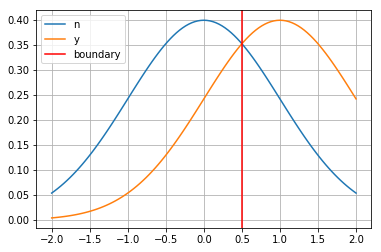

In [29]:
noise_mean, noise_variance = 0, 1
xmin, xmax = -2, 2
signal_amplitude = 1
plot_function(gaussian_noise_distribution(noise_mean, noise_variance), min=xmin, max=xmax, label='n')
plot_function(noisy_signal_distribution(signal_amplitude, noise_mean, noise_variance), min=xmin, max=xmax, label='y')
plot_boundary((2*noise_mean + signal_amplitude)/2, label='boundary')
show_graph()

Generalize this model so that the signal itself is variable, i.e. $x \sim N(\mu_x, \sigma_x)$.  

Since the sum of Gaussians is just a Gaussian whose mean is sum of the component Gaussian means and whose variance is the sum of the component Gaussian variances, the pdf of a noisy variable signal, being the sum of a Gaussian signal and Gaussian noise, is itself a Gaussian:

In [30]:
def noisy_gaussian_signal_distribution(mu_x, sigma_squared_x, mu_n, sigma_squared_n):
    return gaussian_distribution(mu_x + mu_n, sigma_squared_x + sigma_squared_n)

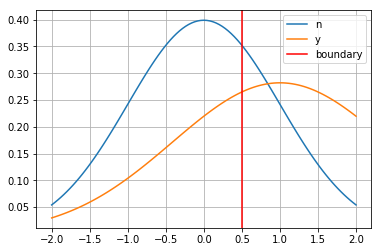

In [31]:
sig_mean, sig_variance = 1, 1
plot_function(gaussian_noise_distribution(noise_mean, noise_variance), min=xmin, max=xmax, label='n')
plot_function(noisy_gaussian_signal_distribution(sig_mean, sig_variance, noise_mean, noise_variance), min=xmin, max=xmax, label='y')
plot_boundary((noise_mean + sig_mean)/2, label='boundary') # TODO: actually plot this right
show_graph()

1.2 Derive the distribution of $y$. (5 pts)

Since $y=x+n$, $y∼N(μ_{x}, σ_{x}^{2}) + N(0, σ_{n}) = N(μ_{x}, σ_{x}^{2} + σ_{n}^{2})$ since the sum of Gaussians is Gaussian as stated above.

1.3 Derive the optimal threshold under this model.  State any assumptions you make. (5 pts) 

We must assume that the signal and noise distributions have the same variance (TODO: ask if we can). (or should it be signal + noise has same variance as noise? not possible as one variance would have to be 0)

1.4 What are the expressions for the probability of a successful detection (a true positive) and of a false alarm (a false positive)? (5 pts)

1.5 Code a functions to calculate these, and use them to plot the ROC curves for different SNRs. Follow the format in Dusenbery-fig.5.2. You should use a toolbox or package that defines common distributions and a cdf function. (5 pts)

### Q2. Detection in a time-varying signal (15 points) {-}

Now assume your signals are time-varying: $y(t) = x(t) + n(t)$.  Assume again Gaussian noise, $y(t) \sim N(0, \sigma_n)$, and for simplicity, that $t$ is discrete and the measured samples $y(t)$ are independent.  The signal $x(t)$, however, only arrives at random intervals and is zero elsewhere.  Events that arrive at random, independent invervals obey Poisson statistics, and the interval can be modeled with an exponential distribution.

2.1 Write code to generate signals from this model. (5 pts)

In [61]:
# domain: the x axis of the signal
# lamb: lambda parameter of the exponential distribution
def poisson_point_process(domain, lamb):
    # get intervals between signal by sampling from exponential distribution
    # and sample the signal at each of those points from the gaussian
    steps = domain.shape[0]
    codomain = np.zeros(domain.shape)
    step = 0
    while True:
        step += int(np.random.exponential(1.0/lamb))
        if step >= steps:
            return codomain
        else:
            # TODO: ask in class if signal is supposed to be constant or Gaussian, here we're just setting it to a constant
            codomain[step] = 2 # TODO: I also set this to 2 arbitrarily


def poisson_signal(lamb):
    return lambda a: poisson_point_process(a, lamb)


def noisy_poisson_signal(lamb, mu_n, sigma_squared_n):
    return lambda a: poisson_point_process(a, lamb) + np.random.normal(mu_n, sigma_squared_n**.5, a.shape)

2.2 Derive the optimal threshold detector for this scenario.  Be sure to consider the probability of the signal being present in any particular sample.  Contrast this with the threshold in Q1. (5 pts)

In [46]:
# TODO

2.3 Write code to plot your generated signal and illustrate threshold detection with a roughly 95% true positive rate. (5 pts)

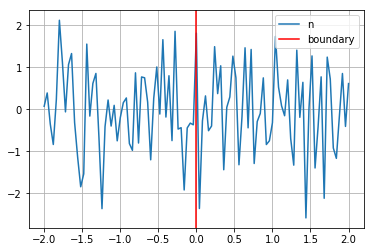

In [47]:
plot_function(noisy_poisson_signal(.1, noise_mean, noise_variance), min=-2, max=2, label='n')
plot_boundary(0, label='boundary') # TODO: actually plot this right
show_graph()
# TODO

### Q3. Spectra and Spectrograms (15 points) {-}

3.1 Read the bach.wav file and plot its Fourier spectrum. (5 pts)

In [296]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')

# normaleze the audio data for easier processing, copied from pgm homework 5
def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

signal = audionorm(dataBach)

In [ ]:
# plot the Fourier spectrum

3.2 Plot the spectrogram (i.e. the time-varying spectrum).  Choose a time interval, windowing, and other parameters such that the individual notes and their harmonics are clearly visible.  Be sure to explain your choices. (5 pts)

3.3 Plot the spectrogram of the first note. Follow the format in AN-fig.1.4.  This note is called $E_5$, which is the E above middle C, and in common tunings has a pitch of 659 Hz.  Show that this note roughly matches this frequency. (5 pts)

### Q4. Filtering (25 points) {-}

4.1 Write a function to calcuate discrete convolution $y(t) = h(t) * x(t)$.  For pedagogical purposes, do this "by hand", i.e. with for loops, and do not use a built-in function. (5 pts)

$(h*x)(t) = ∑_{𝜏=-∞}^{+∞}h(𝜏)x(t-𝜏)$, but since we can only plot the signal for a discrete window we restrict the sum to within that window in the following convolution function:

In [227]:
def discretely_convolve(h, x):
    y = np.zeros(h.shape)
    for t in range(len(h)):
        for tau in range(len(h)):
            y[t] += h[t] * x[t-tau]
    return y

demonstrate with square pulse

In [228]:
import numpy.ma as ma

def square_pulse_filter(a): # TODO: rename this
    x = np.zeros(a.shape)
    x[:15] = -1
    x[2:14] = 1
    return x

def square_pulse():
    return lambda a: np.array([0 < xi < 10 for xi in range(len(a))])

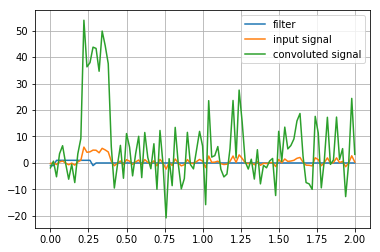

In [232]:
noisy_poisson = noisy_poisson_signal(.1, noise_mean, noise_variance)
square_filter = square_pulse_filter(np.linspace(0, 2, 101))
signal = noisy_poisson(np.linspace(0, 2, 101)) + np.roll(square_pulse()(np.linspace(0, 2, 101))*5, 10)
convoluted_signal = discretely_convolve(signal, square_pulse_filter(np.linspace(0, 2, 101)))

plt.plot(np.linspace(0, 2, 101), square_filter, label='filter')
plt.plot(np.linspace(0, 2, 101), signal, label='input signal')
plt.plot(np.linspace(0, 2, 101), convoluted_signal, label='convoluted signal')
show_graph()

4.2. Write code to define a low-pass filter.  A simple low-pass filter is a Gaussian with a width defined in samples.  Convolving this will take a weighted average of the samples around $x(t)$. (5 pts)

In [247]:
def low_pass_filter(signal, filter_width):
    lp_filter = gaussian_distribution(0, filter_width**2)(np.zeros(signal.shape))
    print(signal.shape)
    print(lp_filter.shape)
    return discretely_convolve(signal, lp_filter)

(101,)
(101,)


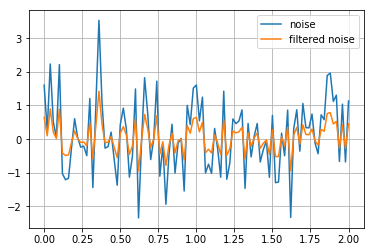

In [260]:
noise = noisy_poisson_signal(.1, noise_mean, noise_variance)(np.linspace(0, 2, 101))
plt.plot(np.linspace(0, 2, 101), noise, label='noise')

plt.plot(np.linspace(0, 2, 101), low_pass_filter(noise, 100), label='filtered noise')
show_graph()

TODO: the above still doesn't seem right, it looks likt it's just smoothing it out?

4.3. Apply your filter to bach.wav.  Illustrate and explain what you did. (5 pts)

4.4. Write a function for a Gaussian-modulated sine wave.  It should take as parameters, frequency (in Hz), width (in samples), and standard deviation (in secs). (5 pts)

In [288]:
def gaussian_modulated_sine(frequency, width, stddev): # TODO: make sure units are right
    # just multiply the two signals together
    # TODO: none of these units/numbers are actually right, fix them
    domain = np.linspace(-1, 1, width)
    gaussian = gaussian_distribution(0, stddev**2)(domain)
    sine = np.sin(domain*frequency/2)
    return gaussian * sine

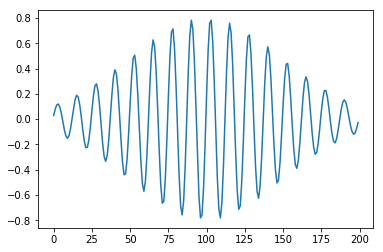

In [293]:
plt.plot(gaussian_modulated_sine(100, 200, .5))
plt.show()

4.5 Use your above function to make a "matched" filter for the first note.  Convolve this filter with bach.wav and illustrate the extent to which this simplistic scheme is able to detect occurences of the note $E_5$ in the audio.  For reference, the music, with the $E_5$ notes circled in red is below.  The audio goes a little beyond what is show, but the note doesn't occur there. (5 pts)

![bach.wav music](bach-music.png)

### Q5. Questions about the Readings (10 points) {-}

5.1 Summarize the evidence that we can detect single photons. (5 pts)

5.2 Summarize the evidence that the some animals can detect sounds that result in *subatomic* vibrations of their eardrum. (5 pts)

### Q6. Exploration (10 points) {-}

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here is the grading rubric:

- Was the topic clearly described and concise? (3 pts)

- Were the relevant concepts clearly explained? (3 pts)

- Did the problem go beyond or is distinct from what was already convered in the questions above? (4 pts)